In [9]:
import pandas as pd
from pathlib import Path

from classifier.training.utils import set_seed
from notebooks.notebook_utils import plot_label_dist

set_seed(42)

DATASET_TYPE = 'positions'
SRC_DATASET_ROOT = Path('./fn-content-dataset')
SRC_DATASET_NAME = f'images__{DATASET_TYPE}.parquet'

In [10]:
df = pd.read_parquet(f'./../{SRC_DATASET_NAME}')
file_names = df[['file_name']]
label_df = df.drop(['file_name'], axis=1)
label_df.shape

(622930, 28)

In [11]:
if DATASET_TYPE == 'positions':
    label_df = label_df.fillna(0).astype(int)
    to_drop = ['69', 'fpov', 'orgy', '1f', '2f', '3f', '1m', '2m', '3m', '1f1m', '1f2m', '2f1m', 'stand cradle']
    label_df = label_df.drop(to_drop, axis=1)
    only_positives = label_df.sum(axis=1) > 0
    label_df = label_df[only_positives]
    file_names = file_names[only_positives]

    merged_ = file_names.merge(label_df, left_index=True, right_index=True)
    merged_.reset_index(inplace=True, drop=True)
    merged_.to_parquet(f'clean_{DATASET_TYPE}.parquet', index=False)

    # Reducing
    reduced = label_df.copy()
    for col in ['laying down', 'sitting']:
        _to_be_reduced = reduced[(reduced[col] == 1) & (reduced.sum(axis=1) == 1)]
        reduced = reduced.drop(_to_be_reduced.index, axis=0, inplace=False)

    label_df = reduced.copy()

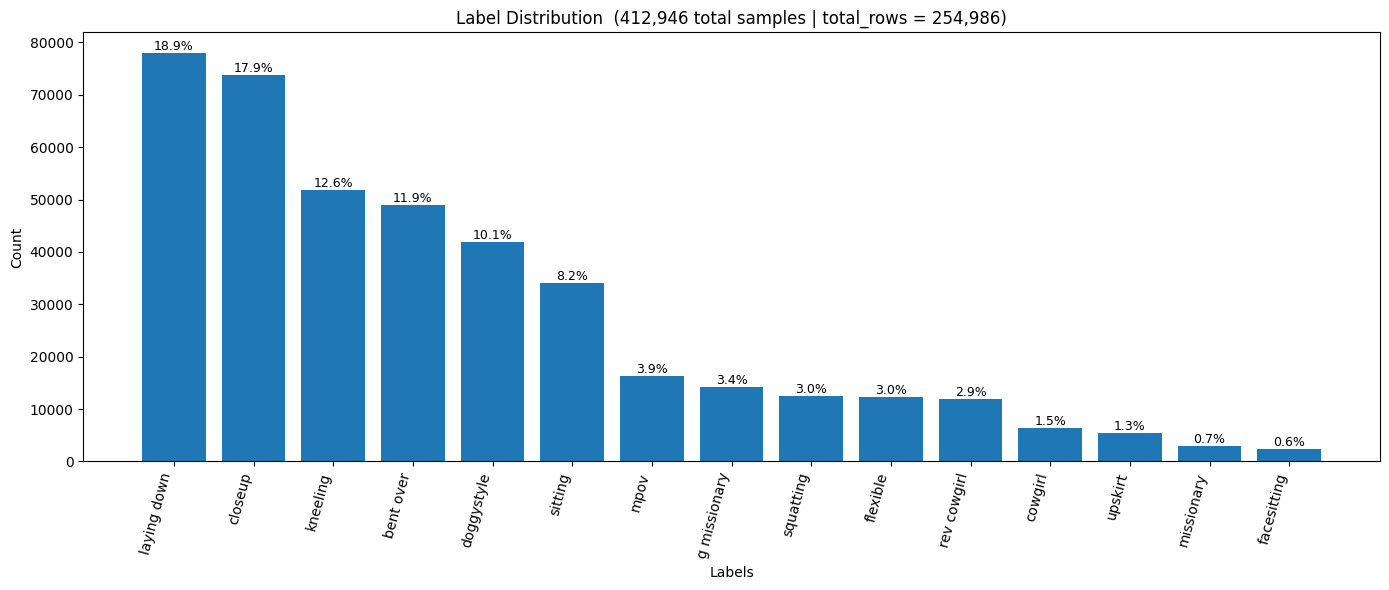

laying down     78020
closeup         73805
kneeling        51858
bent over       49053
doggystyle      41803
sitting         34033
mpov            16275
g missionary    14241
squatting       12521
flexible        12219
rev cowgirl     11947
cowgirl          6370
upskirt          5403
missionary       2965
facesitting      2433
dtype: int64

In [12]:
plot_label_dist(label_df)

# Get only the labels below a certain threshold

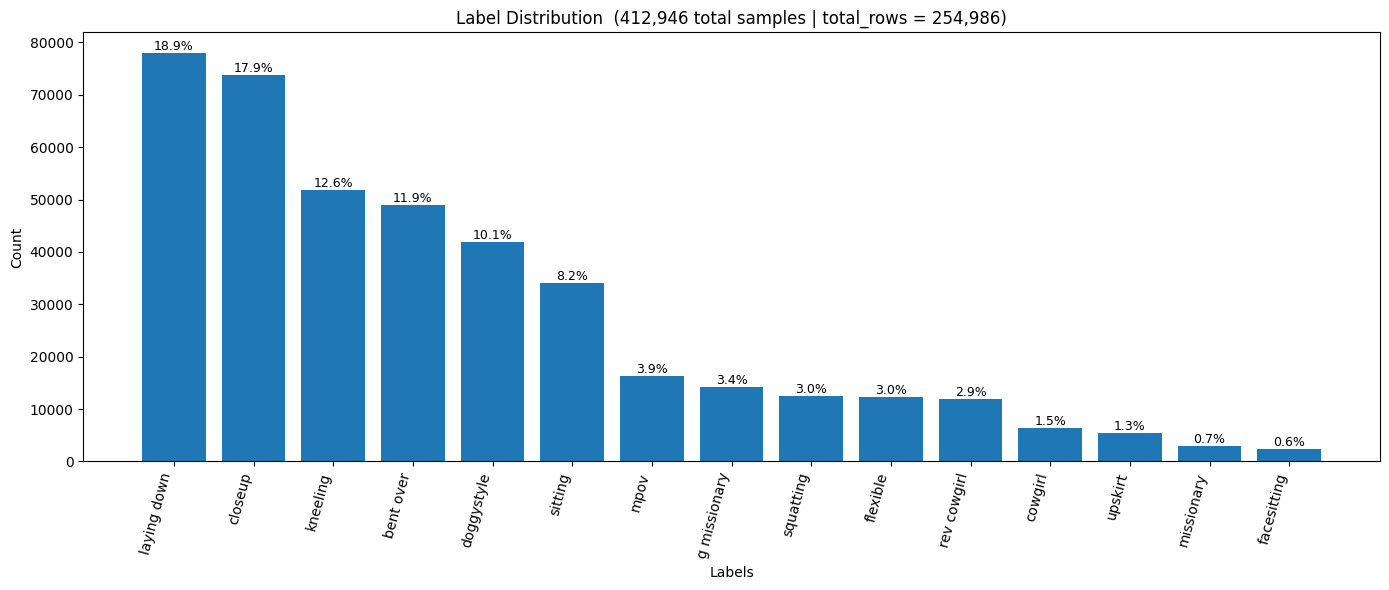

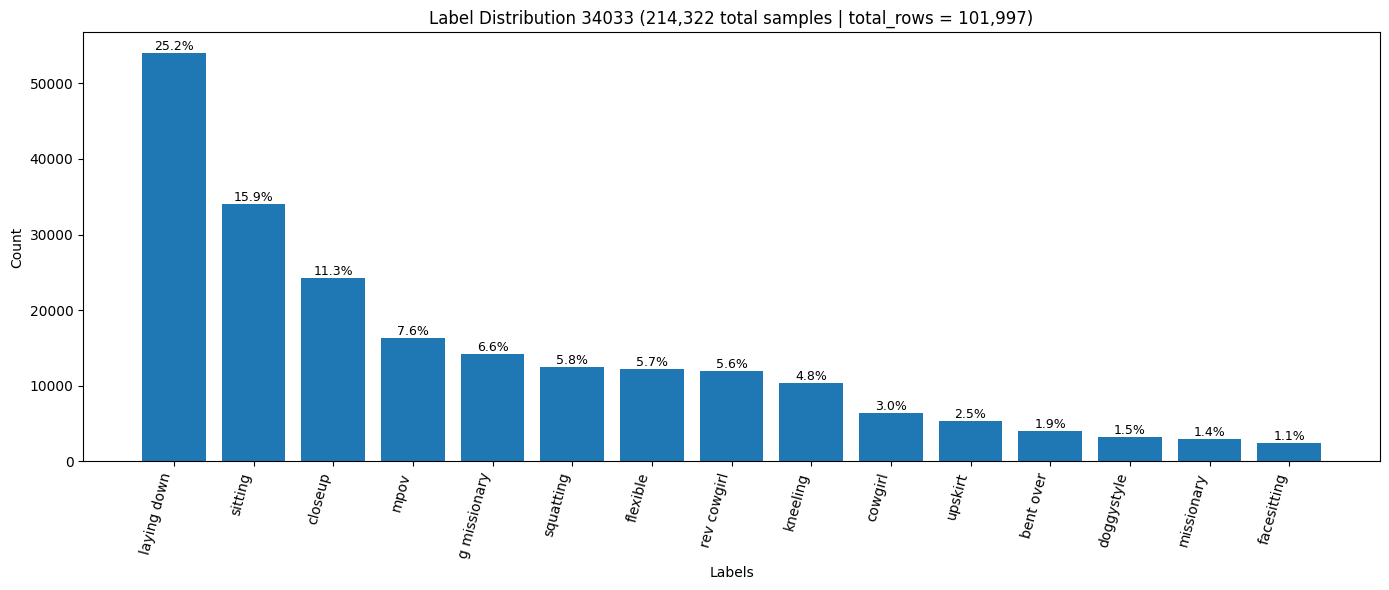

laying down     54031
sitting         34033
closeup         24300
mpov            16275
g missionary    14241
squatting       12521
flexible        12219
rev cowgirl     11947
kneeling        10343
cowgirl          6370
upskirt          5403
bent over        4052
doggystyle       3189
missionary       2965
facesitting      2433
dtype: int64

In [14]:
if DATASET_TYPE == 'actions':
    threshold = 27498
elif DATASET_TYPE == 'bodyparts':
    threshold = 44051
elif DATASET_TYPE == 'positions':
    threshold = 34033  #41517 or 51271
else:
    raise Exception(f'Dataset type {DATASET_TYPE} is not supported.')

filtered_counts = plot_label_dist(label_df)
#
# from tqdm import tqdm
#
# for threshold in tqdm(filtered_counts.values):
sampled_labels = filtered_counts[filtered_counts <= threshold].index.tolist()
original_labels = label_df.columns.tolist()

sampled_df = label_df[sampled_labels].copy()
_zero_labels_filter = sampled_df.sum(axis=1) != 0
sampled_df = sampled_df[_zero_labels_filter]

sampled_index = sampled_df.index.tolist()
_merge_filter = label_df.index.isin(sampled_index)

_label_df = label_df.loc[_merge_filter]
_file_names = file_names.loc[_label_df.index]
plot_label_dist(_label_df, name=str(threshold))

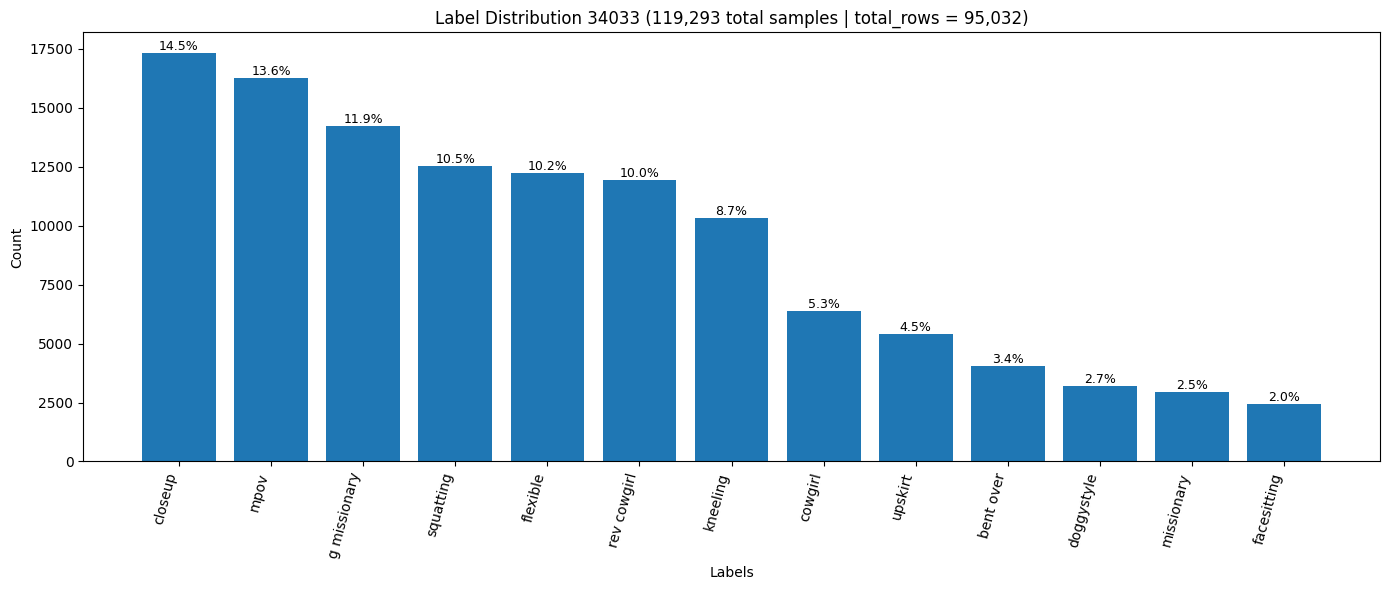

closeup         17335
mpov            16275
g missionary    14241
squatting       12521
flexible        12219
rev cowgirl     11947
kneeling        10343
cowgirl          6370
upskirt          5403
bent over        4052
doggystyle       3189
missionary       2965
facesitting      2433
dtype: int64

In [15]:
if DATASET_TYPE == 'positions':
    __reduced = _label_df.drop(['laying down', 'sitting'], axis=1)
    _r = __reduced[(__reduced.sum(axis=1) == 1) & (__reduced['closeup'] == 1)]
    __reduced = __reduced.drop(_r.index, axis=0, inplace=False)
    label_df = __reduced.copy()

plot_label_dist(label_df, name=str(threshold))

In [16]:
merged_ = file_names.merge(label_df, left_index=True, right_index=True)
merged_.reset_index(inplace=True, drop=True)
merged_.shape
merged_.to_parquet(f'balanced_{DATASET_TYPE}.parquet', index=False)